In [288]:
import pandas as pd
import numpy as np
import nltk
import string
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [91]:
data = pd.read_csv("kud-consolidate/training_data.csv")

In [92]:
data.head()

,type,kud_date,kud_text,kud_amount,toto_date,toto_text,toto_amount,label
0,onetomany,11.04.2019,MobilePay Caroline Boje,-100.0,11.04.2022,Gift Uffe,100.0,0
1,onetomany,11.04.2019,MobilePay Caroline Boje,-100.0,11.04.2022,Parcheggio,100.0,0
2,onetomany,11.04.2019,MobilePay Caroline Boje,-100.0,29.04.2019,Cleaning lady,100.0,0
3,onetomany,11.04.2019,MobilePay Caroline Boje,-100.0,23.04.2019,Cleaning lady,100.0,0
4,onetomany,11.04.2019,MobilePay Caroline Boje,-100.0,14.04.2019,Cleaning lady,100.0,0


In [93]:
stopwords_vocab = set(stopwords.words("english")).union(set(stopwords.words("danish")))
punctuation_symbols = list(string.punctuation)

In [94]:
stemmer = PorterStemmer()

In [95]:
def tokenize(desc): 
    '''
    Tokenizes a description and applies the following:
     - removes stop words
     - removes useless characters (e.g. '-')
     - stems the word
    '''
    # Split descriptions into tokens
    if isinstance(desc, (float, int)): 
        print(f"Weird value: {desc}")
        return desc
    
    tokens = desc.split()
    
    # Filter out stopwords
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stopwords_vocab]
    filtered_tokens = [word for word in filtered_tokens if word not in punctuation_symbols]
    
    # Perform stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # Join the tokens, as needed by TF-IDF
    joined_tokens = " ".join(stemmed_tokens)
    
    return joined_tokens

In [96]:
data["kud_text_tok"] = data["kud_text"].apply(tokenize)
data["toto_text_tok"] = data["toto_text"].apply(tokenize)

In [97]:
kud_text_values = data["kud_text_tok"].values
toto_text_values = data["toto_text_tok"].values

text_values = np.concatenate((kud_text_values, toto_text_values))

documents = []
for i in range(len(text_values)): 
    text = text_values[i]
    documents.append(TaggedDocument(words=text.split(' '), tags=[f"doc_{i}"]))

In [98]:
embeddings_model = Doc2Vec(vector_size=50, window=2, min_count=1, workers=4, epochs=100)
embeddings_model.build_vocab(documents)
embeddings_model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)


In [99]:
embeddings_model.infer_vector("solrød apotek 64052".split(" "))

array([ 0.06686661,  0.01795453,  0.27118158, -0.12521023, -0.03981103,
       -0.22189301, -0.03018903,  0.4782686 , -0.10289858, -0.15553473,
       -0.06561872, -0.38542688,  0.12826173,  0.21399541,  0.02128394,
       -0.23672977,  0.20244637, -0.09573106, -0.09111859, -0.07737637,
       -0.15805775, -0.30488244,  0.19433035,  0.33365571, -0.08598563,
       -0.09899695,  0.25452796,  0.10345838, -0.03988318,  0.02267853,
       -0.25789863, -0.14769918,  0.13253579, -0.10138705,  0.28880674,
        0.21728599,  0.16806084, -0.23459052, -0.01388756, -0.04419716,
        0.23111735, -0.00848597, -0.02470434,  0.05207233,  0.27436593,
       -0.23363268, -0.1788764 , -0.10468192, -0.15875517,  0.15368883],
      dtype=float32)

### Calculate Date Difference

In [100]:
data["kud_date"] = pd.to_datetime(data['kud_date'], format='%d.%m.%Y')
data["toto_date"] = pd.to_datetime(data['toto_date'], format='%d.%m.%Y')

In [101]:
data['date_difference'] = abs(data['toto_date'] - data['kud_date']).dt.days.astype(np.int32)

### Adding Cosine Similarity to features

In [312]:
def feature_cossim(row): 
    ke = embeddings_model.infer_vector(row["kud_text_tok"].split(" "))
    te = embeddings_model.infer_vector(row["toto_text_tok"].split(" "))

    sim = cosine_similarity(ke.reshape(1, -1), te.reshape(1, -1))
    
    return sim[0, 0]

data['cos_sim'] = data.apply(feature_cossim, axis=1)

## Training

In [313]:
data_features = data[["kud_text_tok", "toto_text_tok", "date_difference", "cos_sim", "label"]]
data_features.describe()

,date_difference,cos_sim,label
count,1873.000000,1873.000000,1873.000000
mean,97.435131,0.550443,0.461292
std,311.820855,0.238567,0.498633
min,0.000000,-0.310793,0.000000
25%,0.000000,0.403063,0.000000
50%,1.000000,0.532409,0.000000
75%,3.000000,0.681183,1.000000
max,1846.000000,0.996226,1.000000


In [315]:
data_features["date_diff_norm"] = (data_features["date_difference"] - data_features["date_difference"].mean()) / data_features["date_difference"].std()
data_features.describe()

/tmp/ipykernel_14628/4162542229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features["date_diff_norm"] = (data_features["date_difference"] - data_features["date_difference"].mean()) / data_features["date_difference"].std()


,date_difference,cos_sim,label,date_diff_norm
count,1873.000000,1873.000000,1873.000000,1.873000e+03
mean,97.435131,0.550443,0.461292,3.034886e-17
std,311.820855,0.238567,0.498633,1.000000e+00
min,0.000000,-0.310793,0.000000,-3.124715e-01
25%,0.000000,0.403063,0.000000,-3.124715e-01
50%,1.000000,0.532409,0.000000,-3.092645e-01
75%,3.000000,0.681183,1.000000,-3.028506e-01
max,1846.000000,0.996226,1.000000,5.607594e+00


In [316]:
data_features[data_features["date_difference"] == 0].head(2)

,kud_text_tok,toto_text_tok,date_difference,cos_sim,label,date_diff_norm
5,mobilepay carolin boje,clean ladi,0,0.510188,1,-0.312472
13,mobilepay pasfoto hbg1,visa russia photo,0,0.300812,1,-0.312472


In [349]:
X = []
y = []

for training_ex in data_features.values: 

    kud_text = training_ex[0]
    toto_text = training_ex[1]
    
    kud_text_emb = embeddings_model.infer_vector(kud_text.split(" "))
    toto_text_emb = embeddings_model.infer_vector(toto_text.split(" "))
    
    x = np.concatenate((kud_text_emb, toto_text_emb, [training_ex[3]], [training_ex[2]]))
    
    X.append(x)
    y.append(training_ex[4])

X = np.array(X)

### Model Training

In [350]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1)

model = MLPClassifier(hidden_layer_sizes=(90,80), alpha=1, random_state=1, max_iter=500)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)

training_acc = accuracy_score(y_train, y_train_pred)
training_cm = confusion_matrix(y_train, y_train_pred)

In [351]:
y_test_pred = model.predict(X_test)

test_acc = accuracy_score(y_test, y_test_pred)
test_cm = confusion_matrix(y_test, y_test_pred)

print(test_acc)

0.7224199288256228


Text(0.5, 1.0, 'Test Acc: 72.24')

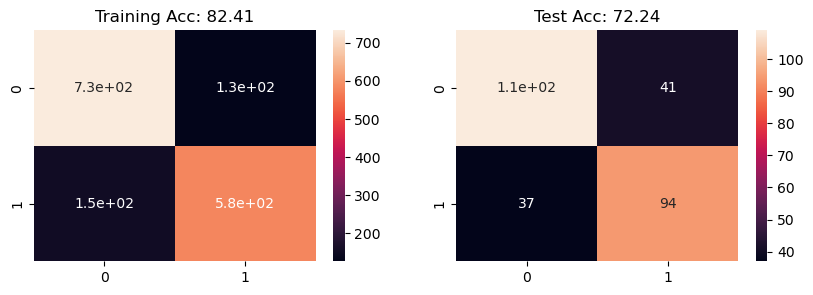

In [352]:
plt.figure(figsize=(10, 3))

plt.subplot2grid((1, 2), (0,0))
sns.heatmap(training_cm, annot=True)
plt.title(f"Training Acc: {100*training_acc:.2f}")

plt.subplot2grid((1, 2), (0,1))
sns.heatmap(test_cm, annot=True)
plt.title(f"Test Acc: {100*test_acc:.2f}")

In [371]:
test_kud1 = embeddings_model.infer_vector("b skat 01 2021".split(" "))
test_toto1 = embeddings_model.infer_vector("b skat 05 2022".split(" "))
date_diff1 = 1

cos_sim = cosine_similarity(test_kud1.reshape(1, -1), test_toto1.reshape(1, -1))

pred_1 = model.predict(np.array([np.concatenate([test_kud1, test_toto1, [cos_sim[0,0]], [date_diff1]])]))[0]
print(f"Sentence similarity: {pred_1}")
print(f"Cosine similarity: {cos_sim}")

Sentence similarity: 1
Cosine similarity: [[0.94326365]]
